## Setup

In [1]:
# mamba create -n binding -c conda-forge python jupyter ipython uncertainties lmfit scipy numpy emcee numba corner matplotlib numdifftools


# Import necessary modules. 
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import scipy as sp
from numba import jit # this package is very valuable for increasing the efficiency of the script
#from optimparallel import minimize_parallel  # not required but can be useful if you want to do parallel LBGFS
from IPython.display import display, Markdown # lets us print tables of values tables using standard iPython
from uncertainties import ufloat,umath
import lmfit,emcee,corner
from multiprocessing import Pool,cpu_count
import os

plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = "Arial"
plt.rcParams['font.size'] = 8

# Set everything up - all functions for fitting
# 
# #https://github.com/numba/numba/issues/1269#issuecomment-702665837
# This solution enables us to apply the overloaded np.prod function along a single axis, see link above
@jit(nopython=True)
def apply_along_axis_0(func1d, arr):
    """Like calling func1d(arr, axis=0)"""
    if arr.size == 0:
        raise RuntimeError("Must have arr.size > 0")
    ndim = arr.ndim
    if ndim == 0:
        raise RuntimeError("Must have ndim > 0")
    elif 1 == ndim:
        return func1d(arr)
    else:
        result_shape = arr.shape[1:]
        out = np.empty(result_shape, arr.dtype)
        _apply_along_axis_0(func1d, arr, out)
        return out

# This solution enables us to apply the overloaded np.prod function along a single axis, see link above
@jit
def _apply_along_axis_0(func1d, arr, out):
    """Like calling func1d(arr, axis=0, out=out). Require arr to be 2d or bigger."""
    ndim = arr.ndim
    if ndim < 2:
        raise RuntimeError("_apply_along_axis_0 requires 2d array or bigger")
    elif ndim == 2:  # 2-dimensional case
        for i in range(len(out)):
            out[i] = func1d(arr[:, i])
    else:  # higher dimensional case
        for i, out_slice in enumerate(out):
            _apply_along_axis_0(func1d, arr[:, i], out_slice)

# This function solves the equilibrium concentration problem based on equilibrium constants, adapted
# from Maeder and co workers: https://doi.org/10.1016/S0922-3487(07)80006-2
@jit(nopython=True)
def getConcs(eqMat,initComponentConc,logK):
    # now we give a vector containing the (log) equilibrium constants. Be careful
    # with sign because these constants are for formation of the complexes
    # above from the "pure components". 
    K = 10.0**logK

    # make an initial guess. This doesn't need to be good - it should just
    # be nearly-equally bad for all parameters
    initguess = np.array([0,0,0]) + np.mean(initComponentConc)

    # solve the equilibrium problem above using the Newton Raphson method
    comp,spec = DoNR(eqMat,K,initComponentConc,initguess)
    return spec


# This function implements the Newton Raphson method for solving the equilibrium problem
# following: https://doi.org/10.1016/S0922-3487(07)80006-2
@jit(nopython=True)
def DoNR(eqMat,K,initComponentConc,guessCompConc):
    nspecies = len(K)
    ncomp = len(initComponentConc)
    
    initComponentConc[initComponentConc<=0] = 1e-20 # avoids numerical errors. Changed to <=0 rather than == 0 because sometimes small negative errors appear which makes
                                                    # the optimisation impossible
    for iter in range(0,500):

        conc = guessCompConc

        specmat = conc.repeat(nspecies).reshape((-1, nspecies))

        eq3pt47 = apply_along_axis_0(np.prod,specmat**eqMat)
        speciesConc = K * eq3pt47  # eq 3.48

        compTotCalc = eqMat @ speciesConc
        deltaComp = initComponentConc - compTotCalc

        if np.all(np.abs(deltaComp) < 1e-15):
            return compTotCalc,speciesConc

        J = np.zeros((ncomp,ncomp))

        # calculate Jacobian
        for ii in range(0,ncomp):
            for jj in range(0,ncomp):
                J[ii,jj] = np.sum(eqMat[ii,:]*eqMat[jj,:]*speciesConc)
                J[jj,ii] = J[ii,jj]

        deltaConc = np.linalg.lstsq(J, deltaComp)[0].T * conc # , rcond=None
        conc += deltaConc

        while np.any(conc <= 0):
            deltaConc = deltaConc/2
            conc -= deltaConc
            if np.all(np.abs(deltaConc)<1e-15):
                break

    # Only reached if the optimisation does not complete within the available steps (500)
    print("Failed to converge in equilibrium solver doNR")
    print('deltaComp: ',deltaComp)
    print('initComponentConc: ',initComponentConc)
    print('K: ',K)
    # return something here which indicates that the result is wrong
    return 0*compTotCalc,0*speciesConc


def fitfun(params,compConcs,eqMat,specConcs,ret='residual'):
    if type(params) == lmfit.parameter.Parameters:
        parvals = params.valuesdict().values()
    else: 
        parvals = params

    specCalc = []
    for row in compConcs:
        yEq = getConcs(eqMat,row,np.array([0,0,0,*parvals],dtype=np.float64))
        specCalc.append(yEq)
    specCalc = np.array(specCalc)
    #return(specConcs-spec)
    sigma = 1#specConcs*0.05 + np.min(specConcs)/2
    if ret == 'residual':
        return((specConcs-specCalc)/(sigma))
    elif ret == 'concs':
        return specCalc
    else:
        print("Invalid return argument. Options: 'residual' [default] or 'concs'")
        return -1


def logprior(par):
    if par[2]<par[1] or par[1]<par[0]:
        return -np.inf
    if  par[2]>40 or par[2]<8:
        return -np.inf
    if par[1]>10 or par[1]<3:
        return -np.inf
    if par[0]>8 or par[0]<2:
        return -np.inf
    else:
        return 0


def fitfun_mc(params,compConcs,eqMat,specConcs):
    if type(params) == lmfit.parameter.Parameters:
        parvals = list(params.valuesdict().values())
    else: 
        parvals = params
    
    
    params = parvals[:-1]#.valuesdict().values()
    lnsigma = parvals[-1]
    params = [*params][0:len(eqMat)]
    specCalc = []


    # if a param is getting silly, reject by checking against the priors
    lp = logprior(params)
    if np.isinf(lp):
        return lp

    for row in compConcs:
        try:
            yEq = getConcs(eqMat,row,np.array([0,0,0,*params],dtype=np.float64))
        except np.linalg.LinAlgError:
            return -np.inf
        # if the maths doesn't work then the solution is deemed impossible
        specCalc.append(yEq)
    specCalc = np.array(specCalc)

    specNoNaN = np.copy(specConcs)
    specNoNaN[np.isnan(specConcs)] = specCalc[np.isnan(specConcs)]
    return (-0.5*np.sum(
                        ((specNoNaN-specCalc) / np.exp(lnsigma))**2 
                        + np.log(2*np.pi) + 2*lnsigma))


def diffEvolFunc(x,specConcs,compConcs):
    res = fitfun(compConcs,x[0],x[0]*x[1],x[0]*x[1]*x[2])

    return sum((specConcs.flatten() - res)**2)


## Basic least_squares fitting and plots

In [12]:

# defines the speciation of the system
                    #  Nc, Py, DABCO, NcPy NcDABCO Nc2DABCO
eqMat =   np.array([[1, 0, 0, 1,   1,      2],  # Nc
                    [0, 1, 0, 1,   0,      0],     # Py
                    [0, 0, 1, 0,   1,      1]],dtype=np.float64)     # DABCO

# initial assignment of parameters for least_squares solution
params = lmfit.Parameters()
params['logB1'] = lmfit.Parameter('logB1',8,min=3,max=10,vary=True)
params['logB2'] = lmfit.Parameter('logB2',9,min=3,max=14,vary=True)
params['logB3'] = lmfit.Parameter('logB3',18,min=5,max=30,vary=True)

# load experimental NMR data
data = (np.loadtxt('titration-data.csv',skiprows=1,delimiter=','))

compConcs = data[:,0:3]
specConcs = np.copy(data)
specConcs[:,0] = 0 #never see free Nc
specConcs[:,1] = np.nan # ignore pyr
specConcs[:,2] = np.nan  # ignore free DABCO


# detrend data; note that total concentration of Nc seems to rise over time. 
# so we set the constraint that the sum of the concentrations must be 1.99e-4 

totalNc = specConcs[:,3]+specConcs[:,4]+2*specConcs[:,5]
scaleFac = 1.99e-4/totalNc
specConcs[:,3] = specConcs[:,3] * scaleFac
specConcs[:,4] = specConcs[:,4] * scaleFac
specConcs[:,5] = specConcs[:,5] * scaleFac

# least_squares fit
mini = lmfit.Minimizer(fitfun,params,fcn_args=(compConcs,eqMat,specConcs),nan_policy='omit')
mm = mini.minimize(method='leastsq')
mm

In [3]:
def makeFitResidPlot(logKs,compConcs,eqMat,specConcs,figname=None):
    specCalc=  fitfun(logKs,compConcs,eqMat,specConcs,ret='concs')
    specConcsFull = np.copy(specConcs)

    specCalc = np.copy(specCalc[:,3:])
    specConcs=np.copy(specConcs[:,3:])
    plt.gcf().clear()
    sf=1 # fig scale factor from single col
    ms=15 #marker size

    plt.figure(figsize=(sf*85/22.5,sf*70/22.5))
    # plt.scatter(compConcs[:,2],(calcSpec[:,3]-specConcs[:,0])/specConcs[:,0])
    # plt.scatter(compConcs[:,2],(calcSpec[:,4]-specConcs[:,1])/specConcs[:,1])
    # plt.scatter(compConcs[:,2],(calcSpec[:,5]-specConcs[:,2])/specConcs[:,2])

    colours = ['r','k','b']
    points = ['^','s','o']
    plt.scatter(10e3*compConcs[:,2],10e6*(specConcs[:,0]-specCalc[:,0]),marker=points[0],c=colours[0],label="ZnNc${\cdot}$pyridine",s=ms)
    plt.scatter(10e3*compConcs[:,2],10e6*(specConcs[:,1]-specCalc[:,1]),marker=points[1],c=colours[1],label="ZnNc${\cdot}$DABCO",s=ms)
    plt.scatter(10e3*compConcs[:,2],10e6*(specConcs[:,2]-specCalc[:,2]),marker=points[2],c=colours[2],label="ZnNc$_{2}{\cdot}$DABCO",s=ms)


    plt.legend()
    plt.xlabel('[DABCO]$_{tot}$ (mM)')
    plt.ylabel("[species]$_{expt}$ - [species]$_{calc}$ (μM)")
    if figname is not None:
        plt.savefig(figname+'-residuals.pdf', bbox_inches="tight")
        plt.savefig(figname+'-residuals.png',dpi=1200, bbox_inches="tight")

    plt.show()

    # calculate more continuous range of concentrations

    concrange = np.arange(0,np.max(compConcs[:,2])+np.max(compConcs[:,2])/50,np.max(compConcs[:,2])/102)
    staticConc = compConcs[0,0]

    compFull = np.ones([len(concrange),3])*staticConc
    compFull[:,2] = concrange
    calcSpecFull = calculateSpeciation(eqMat,compFull,logKs)



    plt.figure(figsize=(sf*85/22.5,sf*70/22.5))
    #plt.subplot(212)
    plt.scatter(10e3*compConcs[:,2],10e3*specConcsFull[:,0],marker=points[0],c='green',label="M",s=ms)

    plt.scatter(10e3*compConcs[:,2],10e3*specConcs[:,0],marker=points[0],c=colours[0],label="M${\cdot}$L$_A$",s=ms)
    plt.scatter(10e3*compConcs[:,2],10e3*specConcs[:,1],marker=points[1],c=colours[1],label="M${\cdot}$L$_B$",s=ms)
    plt.scatter(10e3*compConcs[:,2],10e3*specConcs[:,2],marker=points[2],c=colours[2],label="M$_{2}{\cdot}$L$_B$",s=ms)

    plt.plot(10e3*compFull[:,2],10e3*calcSpecFull[:,0],c='green')
    plt.plot(10e3*compFull[:,2],10e3*calcSpecFull[:,3],c=colours[0])
    plt.plot(10e3*compFull[:,2],10e3*calcSpecFull[:,4],c=colours[1])
    plt.plot(10e3*compFull[:,2],10e3*calcSpecFull[:,5],c=colours[2])

    plt.legend()
    plt.xlabel('[L$_B$]$_{tot}$ (mM)')
    plt.ylabel('[species] (mM)')
    if figname is not None:
        plt.savefig(figname+'.pdf', bbox_inches="tight")
        plt.savefig(figname+'.png',dpi=1200, bbox_inches="tight")

    plt.show()

def calculateSpeciation(eqMat,compConcs,logKs):
    calcSpec = []
    for row in compConcs:
        test = getConcs(eqMat,row,np.array([0,0,0,*logKs]))
        calcSpec.append(test)
    calcSpec = np.array(calcSpec)
    return calcSpec


<>:18: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:48: SyntaxWarning: invalid escape sequence '\c'
<>:49: SyntaxWarning: invalid escape sequence '\c'
<>:18: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:47: SyntaxWarning: invalid escape sequence '\c'
<>:48: SyntaxWarning: invalid escape sequence '\c'
<>:49: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mpeeks\AppData\Local\Temp\ipykernel_5664\1730465328.py:18: SyntaxWarning: invalid escape sequence '\c'
  plt.scatter(10e3*compConcs[:,2],10e6*(specConcs[:,0]-specCalc[:,0]),marker=points[0],c=colours[0],label="ZnNc${\cdot}$pyridine",s=ms)
C:\Users\mpeeks\AppData\Local\Temp\ipykernel_5664\1730465328.py:19: SyntaxWarning: invalid escape sequence '\c'
  plt.scatter(10e3*compConcs

<Figure size 640x480 with 0 Axes>

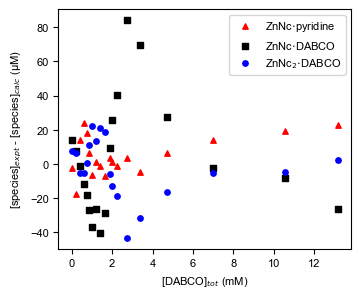

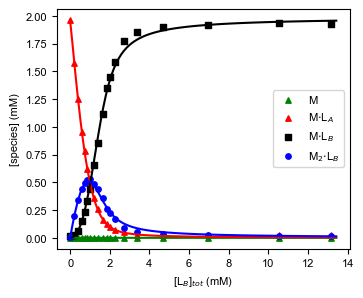

<Figure size 640x480 with 0 Axes>

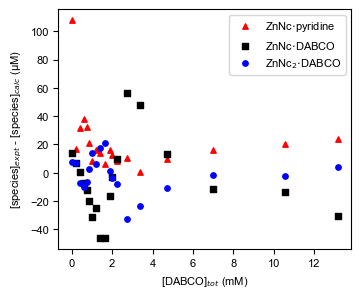

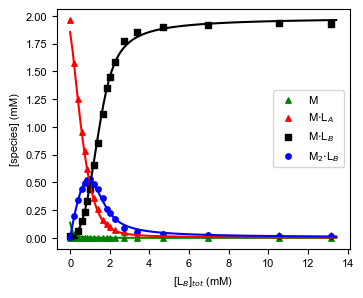

<Figure size 640x480 with 0 Axes>

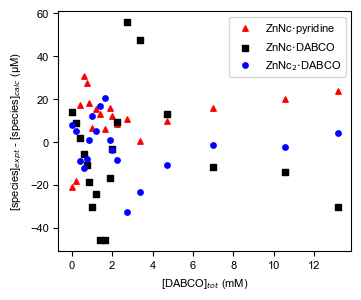

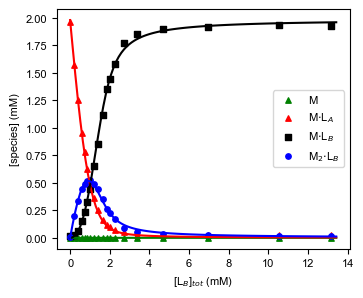

In [4]:

makeFitResidPlot([7.46,9.35,17.31],compConcs,eqMat,specConcs,figname='lsq-result')
Kpy = 6
makeFitResidPlot([Kpy, Kpy+1.98, 2*(Kpy+1.98)-1.45],compConcs,eqMat,specConcs,figname='Kpy-6')

makeFitResidPlot([8.57,10.55,19.65],compConcs,eqMat,specConcs,figname='mle-result')


## MCMC part

In [7]:
# prepare model

nwalkers = 50

variance = .01

params = list(mm.params.valuesdict().values())
params.append(-13)
ndim = len(params)
# prior normal
p = params + variance * np.random.randn(nwalkers,ndim)
# prior is lognormal
p =  np.random.lognormal(np.log(params[:3]), variance,size=(nwalkers,3))



# a better prior recognises that:
# 1. we know that all logB_1 are non-negative
# 2. we know that logB_2 > logB_1
# 3. we know that logB_3 > logB_2

# two obvious options:
# a. create a distribution of logB1, then generate logB2 and logB3 by multiplication by a log-normal distributed scalar (probably mu=0, sigma = 0.5)
# b. create log-normal distribution on each parameter and discard all sets which fail the constraints
# I think the latter is cleaner.


# first make too many walkers:
p =  np.random.lognormal(np.log(params[:3]), variance,size=(10*nwalkers,3))
p=np.append(p, params[3] + variance * np.random.randn(10*nwalkers,1),axis=1)


p = [pp for pp in p if  not np.isinf(logprior(pp))]
# p = [pp for pp in p if  pp[1]>pp[0]]
# # enforce bounds
# p = [pp for pp in p if pp[2]<30 and pp[2]>5]
# p = [pp for pp in p if pp[1]<20 and pp[1]>3]
# p = [pp for pp in p if pp[0]<20 and pp[0]>3]

p = p[:nwalkers]

# check parameterspace

pp = np.array(p)


In [ ]:
# import pickle as pkl
# with open('emcee-40k.pkl','rb') as f:
#     samplerWide = pkl.load(f)

# run model
nstep = 20000
# multiprocessing does not work on Windows in my hands. Works on WSL though.
# with Pool(processes=8) as pool:


pool=None
samplerWide = emcee.EnsembleSampler(nwalkers,ndim,fitfun_mc,pool=pool,args=(compConcs,eqMat,specConcs))
r=samplerWide.run_mcmc(p,nstep,progress=True)

FileNotFoundError: [Errno 2] No such file or directory: 'emcee-40k.pkl'

In [ ]:
tau = samplerWide.get_autocorr_time()
# tau=126
print(tau)
flat_samples = samplerWide.get_chain(discard=int(np.round(np.max(tau)*10)), thin=100, flat=True)

print(params)
plt.figure()
fig=corner.corner(flat_samples,show_titles=True,group='posterior',max_n_ticks=3,divergences=True,labels=[r"$\log{K_1}$",r"$\log{K_2}$",r"$\log{K_3}$",'lnsigma'],quantiles=[0.16,0.5,0.84])#,range=(0.99,.99,.99,.99))#,truths=params)
fig.savefig('corner-plot.pdf', bbox_inches="tight")

## ISMSC sim data


In [10]:
def calculateSpeciation(eqMat,compConcs,logKs):
    calcSpec = []
    for row in compConcs:
        test = getConcs(eqMat,row,np.array([0,0,0,*logKs]))
        calcSpec.append(test)
    calcSpec = np.array(calcSpec)
    return calcSpec

[4.5, 6, 12]


Text(0, 0.5, '[species] M')

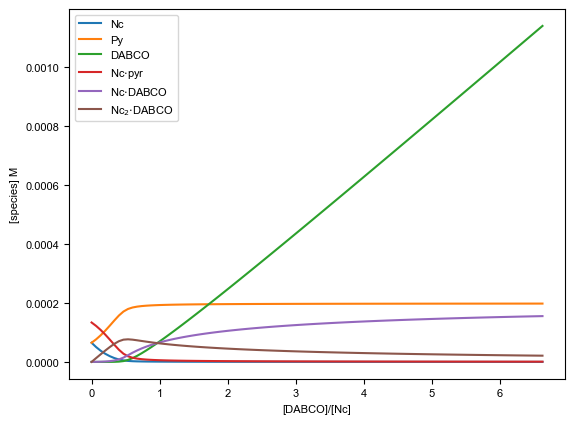

In [13]:

# defines the speciation of the system
                    #  Nc, Py, DABCO, NcPy NcDABCO Nc2DABCO
eqMat =   np.array([[1, 0, 0, 1,   1,      2],  # Nc
                    [0, 1, 0, 1,   0,      0],     # Py
                    [0, 0, 1, 0,   1,      1]],dtype=np.float64)     # DABCO

# load experimental NMR data
data = (np.loadtxt('titration-data.csv',skiprows=1,delimiter=','))

compConcs = data[:,0:3]
compConcs = compConcs
compConcs = np.linspace(compConcs[0,:],compConcs[-1,:],100)

logKs = [xx.value for xx in mm.params.values()]
logKs = np.array(logKs)
logKs = [4.5,6,12]
print(logKs)
simRes = calculateSpeciation(eqMat,compConcs,logKs)
speciesList = ['Nc','Py','DABCO','Nc$\\cdot$pyr','Nc$\\cdot$DABCO','Nc$_2$$\\cdot$DABCO']

plt.plot(compConcs[:,2]/compConcs[:,0],simRes[:,0:])
plt.legend(speciesList[0:])
plt.xlabel('[DABCO]/[Nc]')
plt.ylabel('[species] M')
# plt.xlim(-0.1,2.5)
# plt.ylim(-0.02e-5,.3e-5)
# plt.savefig('DABCO into dilute Nc sim.pdf')
# plt.savefig('DABCO into dilute Nc sim.png')

In [ ]:


# defines the speciation of the system
                    #  Nc, Py, DABCO, NcPy NcDABCO Nc2DABCO
eqMat =   np.array([[1, 0, 0, 1,   1,      2],  # Nc
                    [0, 1, 0, 1,   0,      0],     # Py
                    [0, 0, 1, 0,   1,      1]],dtype=np.float64)     # DABCO

# initial assignment of parameters for least_squares solution
params = lmfit.Parameters()
params['logB1'] = lmfit.Parameter('logB1',8,min=3,max=10,vary=True)
params['logB2'] = lmfit.Parameter('logB2',6,min=3,max=14,vary=True)
params['logB3'] = lmfit.Parameter('logB3',12,min=5,max=30,vary=True)

specConcs = np.copy(simRes)
# add some noise to the simulated data
specConcs = specConcs + np.random.randn(*np.shape(specConcs))*specConcs/100 + np.random.randn(*np.shape(specConcs))*1e-6
specConcs[:,1] = np.nan
specConcs[:,2] = np.nan
# least_squares fit
mini = lmfit.Minimizer(fitfun,params,fcn_args=(compConcs,eqMat,specConcs),nan_policy='omit')
mm = mini.minimize(method='leastsq')
mm


<Figure size 640x480 with 0 Axes>

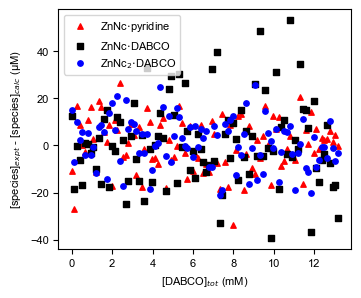

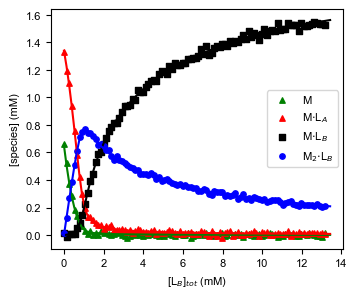

In [15]:
makeFitResidPlot(logKs,compConcs,eqMat,specConcs,figname='lsq-result-simdata')


In [9]:
# prepare model

nwalkers = 10

variance = .05

params = list(mm.params.valuesdict().values())
params.append(-13)
ndim = len(params)
# prior normal
p = params + variance * np.random.randn(nwalkers,ndim)
# prior is lognormal
p =  np.random.lognormal(np.log(params[:3]), variance,size=(nwalkers,3))



# a better prior recognises that:
# 1. we know that all logB_1 are non-negative
# 2. we know that logB_2 > logB_1
# 3. we know that logB_3 > logB_2

# two obvious options:
# a. create a distribution of logB1, then generate logB2 and logB3 by multiplication by a log-normal distributed scalar (probably mu=0, sigma = 0.5)
# b. create log-normal distribution on each parameter and discard all sets which fail the constraints
# I think the latter is cleaner.


# first make too many walkers:
p =  np.random.lognormal(np.log(params[:3]), variance,size=(10*nwalkers,3))
p=np.append(p, params[3] + variance * np.random.randn(10*nwalkers,1),axis=1)
p = [pp for pp in p if  not np.isinf(logprior(pp))]

p = p[:nwalkers]

# check parameterspace

pp = np.array(p)





In [ ]:
nstep = 10000
# multiprocessing does not work on Windows in my hands. Works on WSL though.
# with Pool(processes=8) as pool:


pool=None
samplerWide = emcee.EnsembleSampler(nwalkers,ndim,fitfun_mc,pool=pool,args=(compConcs,eqMat,specConcs))
r=samplerWide.run_mcmc(p,nstep,progress=True)

100%|██████████| 10000/10000 [23:33<00:00,  7.07it/s]


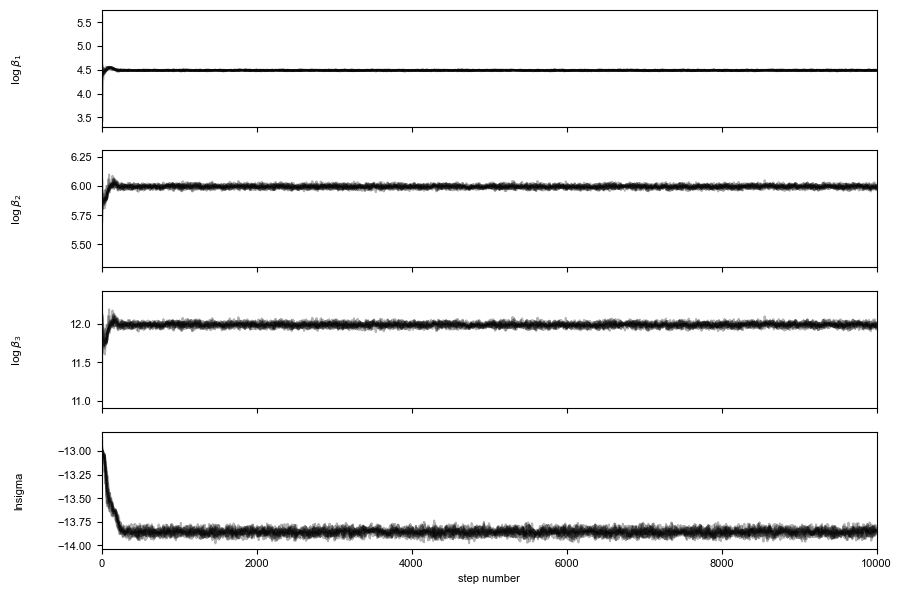

In [ ]:
def plotMCMC(sampler,labels):

    ndim = sampler.ndim
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    #labels = ["k1","k2","lnsigma"] # TODO programmatically generate
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    plt.show()

labels=[r"$\log{\beta_1}$",r"$\log{\beta_2}$",r"$\log{\beta_3}$",'lnsigma']
plotMCMC(samplerWide,labels)

[ 40.0712721   50.51136746  47.05368247 148.98451516]
Parameters([('logB1', <Parameter 'logB1', value=8, bounds=[3:10]>), ('logB2', <Parameter 'logB2', value=6, bounds=[3:14]>), ('logB3', <Parameter 'logB3', value=12, bounds=[5:30]>)])


<Figure size 640x480 with 0 Axes>

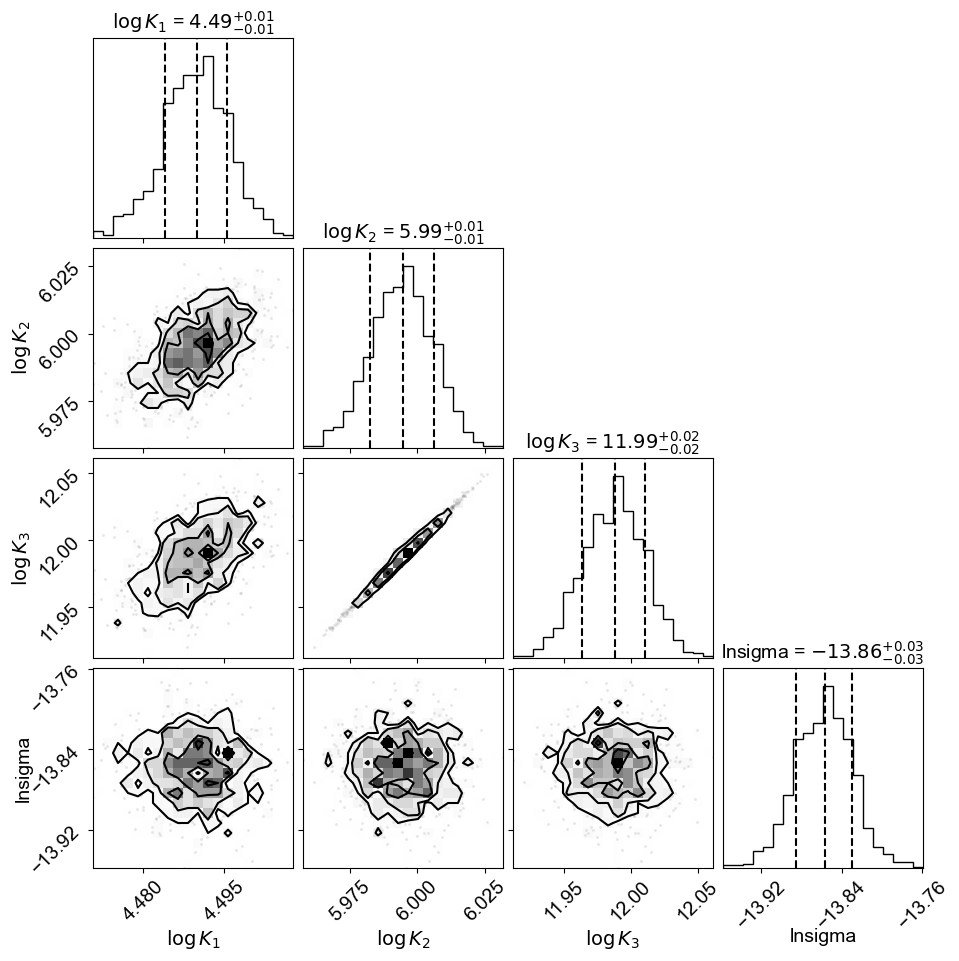

In [191]:
tau = samplerWide.get_autocorr_time()
# tau=126
print(tau)
flat_samples = samplerWide.get_chain(discard=int(np.round(np.max(tau)*10)), thin=100, flat=True)

print(params)
plt.figure()
#corner.corner(flat_samples)
fig=corner.corner(flat_samples,show_titles=True,group='posterior',max_n_ticks=3,divergences=True,labels=[r"$\log{K_1}$",r"$\log{K_2}$",r"$\log{K_3}$",'lnsigma'],quantiles=[0.16,0.5,0.84])#,range=(0.99,.99,.99,.99))#,truths=params)
for ax in fig.get_axes():
    # Adjust major tick labels
    ss=14
    ax.tick_params(axis='both', which='major', labelsize=ss)
    # Adjust minor tick labels
    ax.tick_params(axis='both', which='minor', labelsize=ss)
    ax.title.set_fontsize(ss)
    ax.xaxis.label.set_size(ss)
    ax.yaxis.label.set_size(ss)

plt.savefig('corner-simulated-data-mcmc.pdf')
plt.savefig('corner-simulated-data-mcmc.png')

In [ ]:
np.isnan(specConcs)

array([[False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False],
       [False,  True,  True, False, False, False]])